In [1]:
'''

This code is part of the SIPN2 project focused on improving sub-seasonal to seasonal predictions of Arctic Sea Ice. 
If you use this code for a publication or presentation, please cite the reference in the README.md on the
main page (https://github.com/NicWayand/ESIO). 

Questions or comments should be addressed to nicway@uw.edu

Copyright (c) 2018 Nic Wayand

GNU General Public License v3.0


'''

'''
Plot forecast maps with all available models.
'''

%matplotlib inline
%load_ext autoreload
%autoreload
import matplotlib
#matplotlib.use('Agg')
import matplotlib.pyplot as plt
from collections import OrderedDict
import itertools
import numpy as np
import timeit
import numpy.ma as ma
import pandas as pd
import struct
import os
import xarray as xr
import xesmf as xe
import glob
import datetime
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import seaborn as sns
np.seterr(divide='ignore', invalid='ignore')
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from esio import EsioData as ed
from esio import ice_plot
from esio import import_data


import dask
from dask.distributed import Client


# General plotting settings
sns.set_style('ticks')
sns.set_context("talk", font_scale=.8, rc={"lines.linewidth": 2.5})

In [2]:
client = Client()
client

Client Scheduler: tcp://127.0.0.1:46085 Dashboard: http://127.0.0.1:40299/status,Cluster Workers: 16 Cores: 16 Memory: 67.47 GB


In [3]:
E = ed.EsioData.load()
# Directories
all_models=['rasmesrl']
runType='forecast'


In [4]:
# Plotting Info
runType = 'forecast'
variables = ['sic']
metrics_all = {'sic':['SIP']}
# Some models not to include
MME_NO = ['hcmr']

### Time configuration

In [5]:
# Target time range
valid_start = np.datetime64('2018-09-01')
valid_end = np.datetime64('2018-09-30')

# SIO Report Year_Month
cyear = '2018'
# cmonth = 'June'
# cmonth = 'July'
cmonth = 'August'

# Models that create an Ensemble using different init days
it_target_size = {'usnavysipn':10, 'ukmetofficesipn':21} # Define the number of past days to use TODO: assumes daily inits

In [6]:
# Define custom mod names
custom_names = {'usnavysipn':'NESM','gfdlsipn':'GFDL/NOAA','noaasipn':'NCEP CPC','uclsipn':'UCL','ukmetofficesipn':'Met Office','ecmwfsipn':'ECMWF-c3s'}

In [7]:
# Define models to plot
models_2_plot = list(E.model.keys())
models_2_plot = [x for x in models_2_plot if np.any(x not in ['piomas','MME','modcansipns_3','modcansipns_4','ecmwfsipn']) ] # remove some models
models_2_plot = [x for x in models_2_plot if E.icePredicted[x]] # Only predictive models
models_2_plot

['dampedAnomalyTrend',
 'gfdlsipn',
 'yopp',
 'ukmetofficesipn',
 'ecmwf',
 'metreofr',
 'ukmo',
 'kma',
 'ncep',
 'usnavysipn',
 'usnavyncep',
 'rasmesrl',
 'noaasipn',
 'noaasipn_ext',
 'usnavygofs',
 'uclsipn',
 'szapirosipn',
 'awispin',
 'nicosipn',
 'MME_NEW']

In [8]:
stero_grid_file = E.obs['NSIDC_0051']['grid']
obs_grid = import_data.load_grid_info(stero_grid_file, model='NSIDC')
# Ensure latitude is within bounds (-90 to 90)
# Have to do this because grid file has 90.000001
obs_grid['lat_b'] = obs_grid.lat_b.where(obs_grid.lat_b < 90, other = 90)

In [9]:
# Regridding Options
method='nearest_s2d' # ['bilinear', 'conservative', 'nearest_s2d', 'nearest_d2s', 'patch']

### Load in User submited SIP data

In [10]:
user_sip = [] # Dictionary to store user submitted (regridded) SIP data
r_yr_mon = cyear+'_'+cmonth

import calendar
mon_2_int = {v: k for k,v in enumerate(calendar.month_name)}

### npssipn (RASM)

In [11]:
cmod = 'RASM'
if r_yr_mon=='2018_June':
    sip_f = '/home/disk/sipn/upload/npssipn/forecast/Forecast/RASM_Sep2018_Junreportdata.nc'
elif r_yr_mon=='2018_July':
    sip_f = '/home/disk/sipn/upload/npssipn/forecast/Forecast/RASM_Sep2018_Julyreportdata.nc'
elif r_yr_mon=='2018_August':
    sip_f = '/home/disk/sipn/upload/npssipn/forecast/Forecast/RASM_Sep2018_Aug_reportdata.nc'
else:
    raise ValueError(r_yr_mon,"not found, add sip_f path.")

# Open
ds_user = xr.open_dataset(sip_f)
sip_f = None

# Regrid/format to sipn
ds_user.rename({'lat':'nj', 'long':'ni','longitude':'lon','latitude':'lat'}, inplace=True);
ds_user.set_coords(['lat','lon'], inplace=True)
# Select SIP
da_in = ds_user.SIP_ID
mask = ds_user.Grid_Area.notnull()
da_in = da_in.where(mask)

# Calculate regridding matrix
regridder = xe.Regridder(da_in, obs_grid, method, periodic=False)
# Regrid 
da_out = regridder(da_in)
# Remove weight file
regridder.clean_weight_file() 
# da_in.plot()
# plt.figure()
# da_out.plot()

# Store in dict of user submited SIP
da_out.coords['model'] = cmod
user_sip.append(da_out)

Create weight file: nearest_s2d_720x1280_304x448.nc
Remove file nearest_s2d_720x1280_304x448.nc


### cansips (Mod CanSIPS)

Create weight file: nearest_s2d_50x360_304x448.nc
Remove file nearest_s2d_50x360_304x448.nc


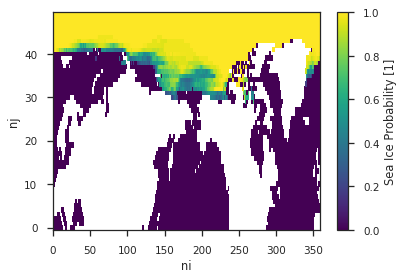

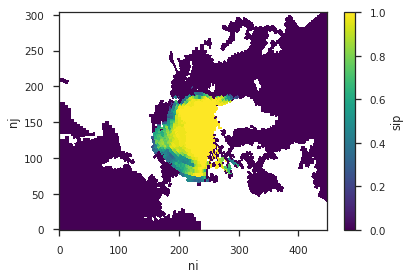

In [12]:
cmod = 'Mod CanSIPS'

if r_yr_mon=='2018_June':
    sip_f = '/home/disk/sipn/upload/ecsipn/Modified_CanSIPS_Sep2018_JuneInit_SIP.nc'
elif r_yr_mon=='2018_July':
    sip_f='/home/disk/sipn/upload/ecsipn/July_2018/Modified_CanSIPS_Sep2018_JulyInit_SIP.nc'
elif r_yr_mon=='2018_August':
    sip_f='/home/disk/sipn/upload/ecsipn/August_2018/Modified_CanSIPS_Sep2018_AugustInit_SIP.nc'
else:
    raise ValueError(r_yr_mon,"not found, add sip_f path.")   
    
ds_user = xr.open_dataset(sip_f)
sip_f = None
ds_user.rename({'lat':'nj', 'lon':'ni','longitude':'lon','latitude':'lat'}, inplace=True);
ds_user.set_coords(['lat','lon'], inplace=True)
# Select SIP
da_in = ds_user.sip.isel(time=0)

# Calculate regridding matrix
regridder = xe.Regridder(da_in, obs_grid, method, periodic=False)
# Regrid 
da_out = regridder(da_in)
# Remove weight file
regridder.clean_weight_file() 
da_in.plot()
plt.figure()
da_out.plot()
# Store in dict of user submited SIP
da_out.coords['model'] = cmod
user_sip.append(da_out)

### nrlsipn (NESM)

In [13]:
# cmod = 'NESM'

# if r_yr_mon=='2018_June':
#     sip_f = '/home/disk/sipn/nicway/data/model/usnavysipn/forecast/metrics_from_nrl/NESM_Sep2018_Maydata_SIP_common.nc'
# elif r_yr_mon=='2018_July':
#     sip_f=''
# else:
#     raise ValueError(r_yr_mon,"not found, add sip_f path.")  

# ds_user = xr.open_dataset(sip_f)
# sip_f = None
# ds_user.rename({'Longitude':'lon','Latitude':'lat'}, inplace=True);
# # Select SIP
# da_in = ds_user.SIP.isel(MT=0)
# da_in = da_in / 100 # scale to 0-1

# # Calculate regridding matrix
# regridder = xe.Regridder(da_in, obs_grid, method, periodic=False)
# # Regrid 
# da_out = regridder(da_in)
# # Remove weight file
# regridder.clean_weight_file() 
# # da_in.plot()
# # plt.figure()
# # da_out.plot()
# # Store in dict of user submited SIP
# da_out.coords['model'] = cmod
# print("Not adding User submited NESM here, Joe wanted us to use our own calculated one")
# #user_sip.append(da_out)

In [14]:
# # Test plot
# da_in.plot()
# plt.figure()
# da_out.plot()

### Sean H.

Create weight file: nearest_s2d_448x304_304x448.nc
Remove file nearest_s2d_448x304_304x448.nc


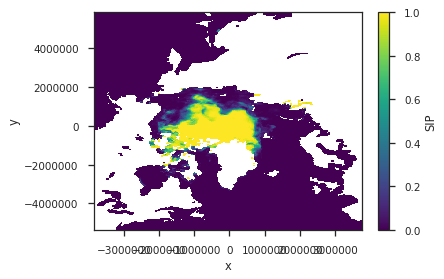

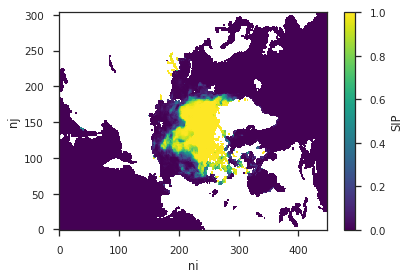

In [15]:
cmod = 'BBGLM\n(Horvath)'

if r_yr_mon=='2018_June':
    sip_f = '/home/disk/sipn/upload/seansipn/forecast/2018_it_June_vt_Sept.nc'
elif r_yr_mon=='2018_July':
    sip_f='/home/disk/sipn/upload/seansipn/forecast/July/2018_it_July_vt_Sept.nc'
elif r_yr_mon=='2018_August':
    sip_f='/home/disk/sipn/upload/seansipn/forecast/August/2018_it_August_vt_Sept.nc'
else:
    raise ValueError(r_yr_mon,"not found, add sip_f path.")  

ds_user = xr.open_dataset(sip_f)
da_in = ds_user.mean(dim='valid_time').SIP

# Calculate regridding matrix
regridder = xe.Regridder(da_in, obs_grid, method, periodic=False)
# Regrid 
da_out = regridder(da_in)
# Remove weight file
regridder.clean_weight_file() 
da_in.plot()
plt.figure()
da_out.plot()
# Store in dict of user submited SIP
da_out.coords['model'] = cmod
user_sip.append(da_out)

In [16]:
da_in

<xarray.DataArray 'SIP' (y: 448, x: 304)>
array([[ 0.,  0.,  0., ..., nan, nan, nan],
       [ 0.,  0.,  0., ..., nan, nan, nan],
       [ 0.,  0.,  0., ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ...,  0.,  0.,  0.],
       [nan, nan, nan, ...,  0.,  0.,  0.],
       [nan, nan, nan, ...,  0.,  0.,  0.]])
Coordinates:
  * y        (y) float64 5.838e+06 5.812e+06 5.788e+06 5.762e+06 5.738e+06 ...
  * x        (x) float64 -3.838e+06 -3.812e+06 -3.788e+06 -3.762e+06 ...
    lon      (y, x) float64 168.3 168.1 168.0 167.8 167.6 167.5 167.3 167.1 ...
    lat      (y, x) float64 31.1 31.2 31.3 31.39 31.49 31.58 31.68 31.77 ...

### Xioajun

Create weight file: nearest_s2d_101x180_304x448_peri.nc
Remove file nearest_s2d_101x180_304x448_peri.nc


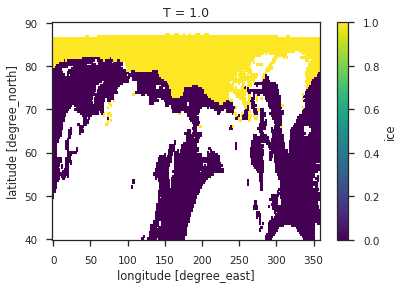

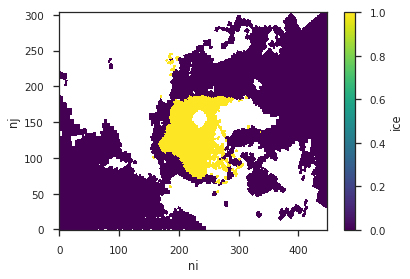

In [17]:
cmod = 'Lamont\n(Yuan et al.)'

if r_yr_mon=='2018_June':
    sip_f = None # no forecast given
elif r_yr_mon=='2018_July':
    sip_f='/home/disk/sipn/nicway/data/model/Xioajun/forecast/native/Xiaojun_Yuan_Yuan_Sep2018_Julydata_SIC_Arctic_native.nc'
elif r_yr_mon=='2018_August':
    sip_f='/home/disk/sipn/nicway/data/model/Xioajun/forecast/native/Yuan_Sep2018_Augustdata_SIC_Arctic_native.nc'    
else:
    raise ValueError(r_yr_mon,"not found, add sip_f path.")  

if sip_f:
    ds_user = xr.open_dataset(sip_f)
    
    da_in = ds_user.rename({'X':'lon','Y':'lat'}).isel(T=0).ice
    da_in = da_in/100
    # SIC to SIP
    da_in = (da_in>0.15).where(da_in.notnull())
    # Calculate regridding matrix
    regridder = xe.Regridder(da_in, obs_grid, method, periodic=True)
    # Regrid 
    da_out = regridder(da_in)
    # Remove weight file
    regridder.clean_weight_file() 
    da_in.plot()
    plt.figure()
    da_out.plot()
    # Store in dict of user submited SIP
    da_out.coords['model'] = cmod
    user_sip.append(da_out)

### NASA GMAO

In [18]:
cmod = 'GMAO'

if r_yr_mon=='2018_June':
    sip_f = None # no forecast given
elif r_yr_mon=='2018_July':
    sip_f='/home/disk/sipn/nicway/data/model/gmao/gmao_Sep2018_Julydata_SIP_thatssmigrid.nc4'
elif r_yr_mon=='2018_August':
    sip_f=None
else:
    raise ValueError(r_yr_mon,"not found, add sip_f path.")  

if sip_f:
    ds_user = xr.open_dataset(sip_f)
    
    ds_user = ds_user.set_coords(['LAT','LON'])
    
    da_in = ds_user.rename({'LON':'lon','LAT':'lat','SIP':'sip'}).sip
    
    da_in = da_in/100 # 100% to 0-1

    # Calculate regridding matrix
    regridder = xe.Regridder(da_in, obs_grid, method, periodic=True)
    # Regrid 
    da_out = regridder(da_in)
    # Remove weight file
    regridder.clean_weight_file() 
    da_in.plot()
    plt.figure()
    da_out.plot()
    # Store in dict of user submited SIP
    da_out.coords['model'] = cmod
    user_sip.append(da_out)

In [19]:
## Merge

In [20]:
usr_SIP = xr.concat(user_sip, dim='model')
usr_SIP = usr_SIP.rename({'nj':'x', 'ni':'y'})
usr_SIP.name = 'SIP'
usr_SIP

<xarray.DataArray 'SIP' (model: 4, x: 304, y: 448)>
array([[[ 0.,  0., ...,  0.,  0.],
        [ 0.,  0., ...,  0.,  0.],
        ...,
        [ 0.,  0., ...,  0.,  0.],
        [ 0.,  0., ..., nan,  0.]],

       [[ 0.,  0., ..., nan, nan],
        [ 0.,  0., ..., nan, nan],
        ...,
        [nan, nan, ...,  0.,  0.],
        [nan, nan, ...,  0.,  0.]],

       [[ 0.,  0., ..., nan, nan],
        [ 0.,  0., ..., nan, nan],
        ...,
        [nan, nan, ...,  0.,  0.],
        [nan, nan, ...,  0.,  0.]],

       [[ 0.,  0., ..., nan, nan],
        [ 0.,  0., ..., nan, nan],
        ...,
        [nan, nan, ...,  0.,  0.],
        [nan, nan, ...,  0.,  0.]]])
Coordinates:
    lon      (x, y) float64 168.3 168.4 168.5 168.7 168.8 168.9 169.0 169.1 ...
    lat      (x, y) float64 31.1 31.25 31.4 31.55 31.69 31.84 31.99 32.13 ...
  * model    (model) <U20 'RASM' 'Mod CanSIPS' 'BBGLM\n(Horvath)' ...
Dimensions without coordinates: x, y
Attributes:
    regrid_method:  nearest_s2d

### Loop through SIPN SIC data and plot those models that have forecasts through target month
- Use most recent init_time (if multiple)
- Use monthly sept mean SIC for each ensemble member to calculate SIP

In [21]:
# Define the last init day as the 11th of the current month's report (i.e. June would be the 11th of June)
last_init_day = np.datetime64(datetime.datetime(int(cyear),mon_2_int[cmonth],11))
# Define the earliest init day as 1 year before last_init_day ( some models init on 1st of month (i.e. UCL))
first_init_day = last_init_day-np.timedelta64(365,'D')
print("Looking for init times between",first_init_day,"and",last_init_day)

Looking for init times between 2017-08-11T00:00:00.000000 and 2018-08-11T00:00:00.000000


In [22]:
# Define fig dir and make if doesn't exist
fig_dir = os.path.join(E.fig_dir, 'model', 'SIO_Reports', cyear, cmonth)
if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)

In [ ]:
for cvar in variables:
    
    # Loop through variable of interest + any metrics (i.e. SIP) based on that
    for metric in metrics_all[cvar]:

        MME_list = []      
    
        # For each model
        for (i, cmod) in enumerate(models_2_plot):
            print("")
            print(cmod)

            # Load in Model
            model_forecast = os.path.join(E.model[cmod][runType]['sipn_nc'], '*.nc') 

            # Check we have files 
            files = glob.glob(model_forecast)
            if not files:
                #print("Skipping model", cmod, "no forecast files found.")
                continue # Skip this model

            start_time = timeit.default_timer()
            ds_model = xr.open_mfdataset(model_forecast, 
                        chunks={'fore_time': 1, 'init_time': 1, 'nj': 304, 'ni': 448}, 
                                         concat_dim='init_time', autoclose=True, parallel=True)
            ds_model.rename({'nj':'x', 'ni':'y'}, inplace=True)
            print("    Loading took  ", (timeit.default_timer() - start_time)/60, " minutes.")

            # Select var of interest (if available)
            if cvar in ds_model.variables:
#                     print('found ',cvar)
                ds_model = ds_model[cvar]
            else:
                print('    cvar not found.')
                continue
                  
            # Select init times
            
            # Use lagged ensemble
            if cmod in list(it_target_size.keys()): # Uses a lagged ensemble... so grab all inits and make them ensembles
                
                # NESM (Joe) wants us to use the past months inits (June for July report)
                if cmod == 'usnavysipn':
                    # Replace last_init_day inline below (note the "-1" meaning last month)
                    ds_model = ds_model.sel(init_time=slice(first_init_day,  np.datetime64(datetime.datetime(int(cyear),mon_2_int[cmonth] - 1, 11))  )) # First get all time between start and stop (up to and including the 10th)
                else:
                    ds_model = ds_model.sel(init_time=slice(first_init_day,last_init_day)) # First get all time between start and stop (up to and including the 10th)
                
                if ds_model.init_time.size==0:
                    print("    No init_times found in requested start range",first_init_day,"to",last_init_day,". So skipping...")
                    continue
                    
                print("    Init times used are",ds_model.init_time[-1*it_target_size[cmod]:].values)    
                
                ds_model = ds_model.sel(init_time=ds_model.init_time[-1*it_target_size[cmod]:]) # Get nearest date to 10th
                avg_init_time = ds_model.init_time.astype('int').median().astype('datetime64[ns]')
                ds_model = ds_model.stack(hybrid_ensemble=('ensemble', 'init_time')).reset_index('hybrid_ensemble')
                ds_model.coords['hybrid_ensemble'] = np.arange(1,ds_model.hybrid_ensemble.size+1,1)
                ds_model = ds_model.drop(['ensemble','init_time'])
                ds_model.coords['init_time'] = avg_init_time
                ds_model = ds_model.rename({'hybrid_ensemble':'ensemble'})
                print(ds_model)

            # Normal Ensemble
            else:
                # Find init time closest and earlier to the 10th of the month
                ds_model = ds_model.sel(init_time=slice(first_init_day,last_init_day)) # First get all time between start and stop (up to and including the 10th)
                if ds_model.init_time.size==0:
                    print("    No init_times found in requested start range",first_init_day,"to",last_init_day,". So skipping...")
                    continue
                ds_model = ds_model.sel(init_time=last_init_day, method='nearest') # Get nearest date to 10th
            print("    Init time used is",ds_model.init_time.values)
                  
            # Get Valid time
            ds_model = import_data.get_valid_time(ds_model.expand_dims('init_time'))
                  
            # Check if we have any valid times in range of target dates
            ds_model = ds_model.where((ds_model.valid_time>=valid_start) & (ds_model.valid_time<=valid_end), drop=True) 
            if ds_model.fore_time.size == 0:
                print("    no fore_time found for target period.")
                continue
                 
            # Average over for_time
            ds_model = ds_model.mean(dim='fore_time')
            
            start_time = timeit.default_timer()
#                 print("Found data for model ", cmod, ". Plotting...")    
            if metric=='mean': # Calc ensemble mean
                ds_model = ds_model.mean(dim='ensemble')
            elif metric=='SIP': # Calc probability
                ok_ens = ((ds_model.notnull().sum(dim='x').sum(dim='y'))>0) # select ensemble members with any data
                ds_model = ((ds_model.where(ok_ens, drop=True)>=0.15) ).mean(dim='ensemble').where(ds_model.isel(ensemble=0).notnull())
            elif metric=='anomaly': # Calc anomaly in reference to mean observed 1980-2010
                ds_model = ds_model.mean(dim='ensemble') - da_obs_mean
                # Add back lat/long (get dropped because of round off differences)
                ds_model['lat'] = da_obs_mean.lat
                ds_model['lon'] = da_obs_mean.lon
            else:
                raise ValueError('metric not implemented')
            print("    Calc metric took  ", (timeit.default_timer() - start_time)/60, " minutes.")

            # Build MME
            if 'ensemble' in ds_model:
                ds_model = ds_model.drop('ensemble')
            if cmod not in MME_NO: # Exclude some models (bad) from MME
                ds_model.coords['model'] = cmod
                MME_list.append(ds_model)
                print('    Added ',cmod,' to MME.')

# Done with current it
print("Took ", (timeit.default_timer() - start_time)/60, " minutes.")

# Concat over all models
ds_MME = xr.concat(MME_list, dim='model')
ds_MME.name = 'SIP'


dampedAnomalyTrend
    Loading took   0.39240518485506376  minutes.
    Init time used is 2018-08-01T00:00:00.000000000
    Calc metric took   0.005305377735445897  minutes.
    Added  dampedAnomalyTrend  to MME.

gfdlsipn
    Loading took   0.01575605821950982  minutes.
    Init time used is 2018-08-01T00:00:00.000000000
    Calc metric took   0.040124821080826226  minutes.
    Added  gfdlsipn  to MME.

yopp
    Loading took   0.26448653417949874  minutes.
    Init time used is 2018-08-11T00:00:00.000000000
    no fore_time found for target period.

ukmetofficesipn


/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/array/core.py:2539: UserWarning: Increasing number of chunks by factor of 26
  (nparts / max_parts))
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/array/core.py:2539: UserWarning: Increasing number of chunks by factor of 28
  (nparts / max_parts))
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/array/core.py:2539: UserWarning: Increasing number of chunks by factor of 31
  (nparts / max_parts))
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/array/core.py:2539: UserWarning: Increasing number of chunks by factor of 30
  (nparts / max_parts))
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/array/core.py:2539: UserWarning: Increasing number of chunks by factor of 29
  (nparts / max_parts))


    Loading took   0.10006645765000334  minutes.
    Init times used are ['2018-07-09T00:00:00.000000000' '2018-07-10T00:00:00.000000000'
 '2018-07-11T00:00:00.000000000' '2018-07-12T00:00:00.000000000'
 '2018-07-13T00:00:00.000000000' '2018-07-14T00:00:00.000000000'
 '2018-07-15T00:00:00.000000000' '2018-07-16T00:00:00.000000000'
 '2018-07-17T00:00:00.000000000' '2018-07-18T00:00:00.000000000'
 '2018-07-19T00:00:00.000000000' '2018-07-20T00:00:00.000000000'
 '2018-07-21T00:00:00.000000000' '2018-07-22T00:00:00.000000000'
 '2018-07-23T00:00:00.000000000' '2018-07-24T00:00:00.000000000'
 '2018-07-25T00:00:00.000000000' '2018-07-26T00:00:00.000000000'
 '2018-07-27T00:00:00.000000000' '2018-07-28T00:00:00.000000000'
 '2018-07-29T00:00:00.000000000']
<xarray.DataArray 'sic' (fore_time: 215, x: 304, y: 448, ensemble: 147)>
dask.array<shape=(215, 304, 448, 147), dtype=float64, chunksize=(1, 304, 448, 21)>
Coordinates:
    lon        (x, y) float64 168.3 168.4 168.5 168.7 168.8 168.9 169.0 ..

/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/array/core.py:2539: UserWarning: Increasing number of chunks by factor of 25
  (nparts / max_parts))
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://127.0.0.1:48564 remote=tcp://127.0.0.1:46085>


    Loading took   3.0822053016939512  minutes.
    Init times used are ['2018-06-08T12:00:00.000000000' '2018-06-09T12:00:00.000000000'
 '2018-06-10T12:00:00.000000000' '2018-06-11T12:00:00.000000000'
 '2018-07-01T12:00:00.000000000' '2018-07-02T12:00:00.000000000'
 '2018-07-03T12:00:00.000000000' '2018-07-04T12:00:00.000000000'
 '2018-07-05T12:00:00.000000000' '2018-07-06T12:00:00.000000000']
<xarray.DataArray 'sic' (fore_time: 153, x: 304, y: 448, ensemble: 10)>
dask.array<shape=(153, 304, 448, 10), dtype=float64, chunksize=(1, 304, 448, 1)>
Coordinates:
  * fore_time  (fore_time) timedelta64[ns] 0 days 12:00:00 1 days 12:00:00 ...
    lon        (x, y) float64 168.3 168.4 168.5 168.7 168.8 168.9 169.0 ...
    lat        (x, y) float64 31.1 31.25 31.4 31.55 31.69 31.84 31.99 32.13 ...
  * ensemble   (ensemble) int64 1 2 3 4 5 6 7 8 9 10
    init_time  datetime64[ns] 2018-07-02
Dimensions without coordinates: x, y
Attributes:
    regrid_method:  nearest_s2d
    Init time used is 2018

distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://127.0.0.1:48582 remote=tcp://127.0.0.1:46085>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://127.0.0.1:48584 remote=tcp://127.0.0.1:46085>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://127.0.0.1:48586 remote=tcp://127.0.0.1:46085>
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/array/core.py:2539: UserWarning: Increasing number of chunks by factor of 17
  (nparts / max_parts))
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/array/core.py:2539: UserWarning: Increasing number of chunks by factor of 16
  (nparts / max_parts))
distributed.nanny - WARNING - Worker exceeded 95% memory budget.  Restarting
distributed.nanny - WARNING - Worker process 30347 was killed by unknown signal
distributed.nanny - WARNING - Restarting worker


In [ ]:
# Take mean over init_time (different models init different times. mean doesn't change values)
model_inits = ds_MME.init_time # Save init_times
models_list = ds_MME.model
ds_MME = ds_MME.mean(dim='init_time')
ds_MME

In [ ]:
# Merge user SIP with SPIN SIP
ds_SIP_All = xr.concat([ds_MME,usr_SIP], dim='model')

In [ ]:
# Load into memory
ds_SIP_All.load()
# Save to disk
ds_SIP_All.to_netcdf('/home/disk/sipn/nicway/data/model/SIO/'+cyear+'/'+cmonth+'/SIP.nc')

In [ ]:
# Load in last results
# ds_SIP_All = xr.open_mfdataset('/home/disk/sipn/nicway/data/model/SIO/'+cyear+'/'+cmonth+'/SIP.nc').SIP
# cvar = 'sic'
# metric = 'SIP'

In [ ]:
ds_SIP_All

In [ ]:
ds_MME_avg = ds_SIP_All.mean(dim='model')
ds_MME_std = ds_SIP_All.std(dim='model')

In [ ]:
# Set up plotting info
if cvar=='sic':
    if metric=='mean':
        cmap_c = matplotlib.colors.ListedColormap(sns.color_palette("Blues_r", 10))
        cmap_c.set_bad(color = 'lightgrey')
        c_label = 'Sea Ice Concentration (-)'
        c_vmin = 0
        c_vmax = 1
    elif metric=='SIP':
        cmap_c = matplotlib.colors.LinearSegmentedColormap.from_list("", ["white","orange","red","#990000"], N=10)
        #cmap_c = plt.get_cmap('jet') 
        cmap_c.set_bad(color = 'lightgrey')
        c_label = 'Sea Ice Probability (-)'
        c_vmin = 0
        c_vmax = 1
    elif metric=='anomaly':
#                         cmap_c = matplotlib.colors.ListedColormap(sns.color_palette("coolwarm", 9))
        cmap_c = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red","white","blue"])
        cmap_c.set_bad(color = 'lightgrey')
        c_label = 'SIC Anomaly to 1980-2010 Mean'
        c_vmin = -1
        c_vmax = 1

elif cvar=='hi':
    if metric=='mean':
        cmap_c = matplotlib.colors.ListedColormap(sns.color_palette("Reds_r", 10))
        cmap_c.set_bad(color = 'lightgrey')
        c_label = 'Sea Ice Thickness (m)'
        c_vmin = 0
        c_vmax = None
else:
    raise ValueError("cvar not found.") 


    
def add_subplot_title(cmod, custom_names, E, ax=None):
    if cmod in custom_names:
        ax.set_title(custom_names[cmod])
    elif cmod in E.model.keys():
        ax.set_title(E.model[cmod]['model_label'])
    else:
        ax.set_title(cmod)

# New Plot
central_extent = [-3850000*0.6, 3725000*0.6, -5325000*0.45, 5850000*0.45] # (x0, x1, y0, y1
(f, axes) = ice_plot.multi_polar_axis(ncols=4, nrows=4, Nplots=20, extent=central_extent, central_longitude=0)

for (i, cmod) in enumerate(ds_SIP_All.model.values):
    print(cmod)
    # Plot
    add_subplot_title(cmod, custom_names, E, ax=axes[i])
    p = ds_SIP_All.sel(model=cmod).plot.pcolormesh(ax=axes[i], x='lon', y='lat', 
                          transform=ccrs.PlateCarree(),
                          add_colorbar=False,
                          cmap=cmap_c,
                          vmin=c_vmin, vmax=c_vmax)
    add_subplot_title(cmod, custom_names, E, ax=axes[i])


# MME Mean
i = i + 1


pmme = ds_MME_avg.plot.pcolormesh(ax=axes[i], x='lon', y='lat', 
                                  transform=ccrs.PlateCarree(),
                                  add_colorbar=False, 
                                  cmap=cmap_c,vmin=c_vmin, vmax=c_vmax)
axes[i].set_title('Mean')


# MME Standard deviation
i = i + 1


pmme = ds_MME_std.plot.pcolormesh(ax=axes[i], x='lon', y='lat', 
                                  transform=ccrs.PlateCarree(),
                                  add_colorbar=False, 
                                  cmap=cmap_c,vmin=c_vmin, vmax=c_vmax)
axes[i].set_title('σ')
    

# Make pretty
f.subplots_adjust(bottom=0.05)
# cbar_ax = f.add_axes([0.85, 0.15, 0.05, 0.7])
cbar_ax = f.add_axes([0.25, 0.001, .5, 0.04]) #  [left, bottom, width, height] w
if p:
    cbar = f.colorbar(p, cax=cbar_ax, label=c_label, orientation='horizontal')
    if metric=='anomaly':
        cbar.set_ticks(np.arange(-1,1.1,0.2))
    else:
        cbar.set_ticks(np.arange(0,1.1,0.2))

# Save to file
f_out = os.path.join(fig_dir,'panArctic_'+metric+'_'+runType+'_'+cyear+'_'+cmonth+'.png')
f.savefig(f_out,bbox_inches='tight', dpi=300)
f_out = os.path.join(fig_dir,'panArctic_'+metric+'_'+runType+'_'+cyear+'_'+cmonth+'_lowRES.png')
f.savefig(f_out,bbox_inches='tight', dpi=90)
print("saved ", f_out)

In [ ]:
# Compare past mean forecasts
ds_SIP_June = xr.open_mfdataset('/home/disk/sipn/nicway/data/model/SIO/'+'2018'+'/'+'June'+'/SIP.nc')
ds_SIP_July = xr.open_mfdataset('/home/disk/sipn/nicway/data/model/SIO/'+'2018'+'/'+'July'+'/SIP.nc')

In [ ]:
july_june_common_models = [x for x in ds_SIP_June.model.values if x not in ['awispin', 'nicosipn','ecmwfsipn']]

In [ ]:
# New Plot
central_extent = [-3850000*0.6, 3725000*0.6, -5325000*0.45, 5850000*0.45] # (x0, x1, y0, y1
(f, axes) = ice_plot.multi_polar_axis(ncols=3, nrows=1, Nplots=20, extent=central_extent, central_longitude=0)

i = 0
pmme1 = ds_SIP_June.mean(dim='model').SIP.plot.pcolormesh(ax=axes[i], x='lon', y='lat', 
                                  transform=ccrs.PlateCarree(),
                                  add_colorbar=False, 
                                  cmap=cmap_c,vmin=c_vmin, vmax=c_vmax)
axes[i].set_title('June Multi\nModel Mean')

i = 1
pmme2 = ds_SIP_July.mean(dim='model').SIP.plot.pcolormesh(ax=axes[i], x='lon', y='lat', 
                                  transform=ccrs.PlateCarree(),
                                  add_colorbar=False, 
                                  cmap=cmap_c,vmin=c_vmin, vmax=c_vmax)
axes[i].set_title('July Multi\nModel Mean')


i = 2
cmap_diff = matplotlib.colors.LinearSegmentedColormap.from_list("", ["blue","white","red",])
cmap_diff.set_bad(color = 'lightgrey')
pmme3 = (ds_SIP_July.sel(model=july_june_common_models).mean(dim='model')-ds_SIP_June.sel(model=july_june_common_models).mean(dim='model')).SIP.plot.pcolormesh(ax=axes[i], x='lon', y='lat', 
                                  transform=ccrs.PlateCarree(),
                                  add_colorbar=False, 
                                  cmap=cmap_diff,vmin=-.2, vmax=.2)
axes[i].set_title('Difference\n(July - June)')


f.subplots_adjust(bottom=0.02)
cbar_ax = f.add_axes([0.25, 0.001, .5, 0.08]) #  [left, bottom, width, height] w
cbar = f.colorbar(pmme2, cax=cbar_ax, label=c_label, orientation='horizontal')
cbar.set_ticks(np.arange(0,1.1,0.2))

cbar_ax_2 = f.add_axes([.93, 0.08, .025, 0.75]) #  [left, bottom, width, height] w
cbar2 = f.colorbar(pmme3, cax=cbar_ax_2, label='SIP Change (-)', orientation='vertical')

# Save to file
f_out = os.path.join(fig_dir,'panArctic_'+metric+'_'+runType+'_'+cyear+'_July_June_diff.png')
f.savefig(f_out,bbox_inches='tight', dpi=300)
print("saved ", f_out)
f_out = os.path.join(fig_dir,'panArctic_'+metric+'_'+runType+'_'+cyear+'_July_June_diff_lowRES.png')
f.savefig(f_out,bbox_inches='tight', dpi=90)
print("saved ", f_out)

In [ ]:
# Set up plotting info
if cvar=='sic':
    if metric=='mean':
        cmap_c = matplotlib.colors.ListedColormap(sns.color_palette("Blues_r", 10))
        cmap_c.set_bad(color = 'lightgrey')
        c_label = 'Sea Ice Concentration (-)'
        c_vmin = 0
        c_vmax = 1
    elif metric=='SIP':
        cmap_c = matplotlib.colors.LinearSegmentedColormap.from_list("", ["white","orange","red","#990000"], N=10)
        #cmap_c = plt.get_cmap('jet') 
        cmap_c.set_bad(color = 'lightgrey')
        c_label = 'Sea Ice Probability (-)'
        c_vmin = 0
        c_vmax = 1
    elif metric=='anomaly':
#                         cmap_c = matplotlib.colors.ListedColormap(sns.color_palette("coolwarm", 9))
        cmap_c = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red","white","blue"])
        cmap_c.set_bad(color = 'lightgrey')
        c_label = 'SIC Anomaly to 1980-2010 Mean'
        c_vmin = -1
        c_vmax = 1

elif cvar=='hi':
    if metric=='mean':
        cmap_c = matplotlib.colors.ListedColormap(sns.color_palette("Reds_r", 10))
        cmap_c.set_bad(color = 'lightgrey')
        c_label = 'Sea Ice Thickness (m)'
        c_vmin = 0
        c_vmax = None
else:
    raise ValueError("cvar not found.") 


    
def add_subplot_title(cmod, custom_names, E, ax=None):
    if cmod in custom_names:
        ax.set_title(custom_names[cmod])
    elif cmod in E.model.keys():
        ax.set_title(E.model[cmod]['model_label'])
    else:
        ax.set_title(cmod)

# New Plot
central_extent = [-3850000*0.6, 3725000*0.6, -5325000*0.45, 5850000*0.45] # (x0, x1, y0, y1
(f, axes) = ice_plot.multi_polar_axis(ncols=4, nrows=4, Nplots=17, extent=central_extent, central_longitude=0)

for (i, cmod) in enumerate(ds_SIP_All.model.values):
    print(cmod)
    # Plot
    add_subplot_title(cmod, custom_names, E, ax=axes[i])
    p = ds_SIP_All.sel(model=cmod).plot.pcolormesh(ax=axes[i], x='lon', y='lat', 
                          transform=ccrs.PlateCarree(),
                          add_colorbar=False,
                          cmap=cmap_c,
                          vmin=c_vmin, vmax=c_vmax)
    add_subplot_title(cmod, custom_names, E, ax=axes[i])


# MME Mean
i = i + 1
# f.delaxes(axes[i])
# i = i + 1
# f.delaxes(axes[i])
# i = i + 1

pmme = ds_MME_avg.plot.pcolormesh(ax=axes[i], x='lon', y='lat', 
                                  transform=ccrs.PlateCarree(),
                                  add_colorbar=False, 
                                  cmap=cmap_c,vmin=c_vmin, vmax=c_vmax)
axes[i].set_title('Mean')


# MME Standard deviation
i = i + 1


pmme = ds_MME_std.plot.pcolormesh(ax=axes[i], x='lon', y='lat', 
                                  transform=ccrs.PlateCarree(),
                                  add_colorbar=False, 
                                  cmap=cmap_c,vmin=c_vmin, vmax=c_vmax)
axes[i].set_title('σ')

# Difference from last SIO
i = i + 1
cmap_diff = matplotlib.colors.LinearSegmentedColormap.from_list("", ["blue","white","red",])
cmap_diff.set_bad(color = 'lightgrey')
pmme3 = (ds_SIP_July.sel(model=july_june_common_models).mean(dim='model')-ds_SIP_June.sel(model=july_june_common_models).mean(dim='model')).SIP.plot.pcolormesh(ax=axes[i], x='lon', y='lat', 
                                  transform=ccrs.PlateCarree(),
                                  add_colorbar=False, 
                                  cmap=cmap_diff,vmin=-.2, vmax=.2)
axes[i].set_title('Difference\n(July - June)')
    

# Make pretty
f.subplots_adjust(bottom=0.05)
# cbar_ax = f.add_axes([0.85, 0.15, 0.05, 0.7])
cbar_ax = f.add_axes([0.25, 0.001, .5, 0.04]) #  [left, bottom, width, height] w
if p:
    cbar = f.colorbar(p, cax=cbar_ax, label=c_label, orientation='horizontal')
    if metric=='anomaly':
        cbar.set_ticks(np.arange(-1,1.1,0.2))
    else:
        cbar.set_ticks(np.arange(0,1.1,0.2))
        

cbar_ax_2 = f.add_axes([0.93, 0.07, .025, .15]) #  [left, bottom, width, height] w
cbar2 = f.colorbar(pmme3, cax=cbar_ax_2, label='SIP Change (-)', orientation='vertical')


# Save to file
f_out = os.path.join(fig_dir,'panArctic_'+metric+'_'+runType+'_'+cyear+'_'+cmonth+'_withDiff.png')
f.savefig(f_out,bbox_inches='tight', dpi=300)
f_out = os.path.join(fig_dir,'panArctic_'+metric+'_'+runType+'_'+cyear+'_'+cmonth+'_withDiff_lowRES.png')
f.savefig(f_out,bbox_inches='tight', dpi=90)
print("saved ", f_out)

In [ ]:
ds_SIP_July.model

In [ ]:
ds_SIP_June.model

In [ ]:
model_inits

In [ ]:
models_list

In [ ]:
# Need to add check -- Compare June to July models (Make sure they are different! (unless they are supposed to be unchanged))